# Real case verification: the Braunsbach event 

**The "Braunsbach event"** -- the hazardous event which took place in Braunsbach town on 29 May 2016 and was triggered by torrential rainfall. 

This event is in strong focus of [the Hydrology and Climatology Group led by Axel Bronstert in the University of Potsdam](http://www.geo.uni-potsdam.de/893.html) and we tested all of our models on this data span for first. Read more in the [paper](https://www.sciencedirect.com/science/article/pii/S0048969718306405).

**Libraries we use**

* [rainymotion](https://github.com/hydrogo/rainymotion) -- models, metrics, pre/postprocessing
* [numpy](http://www.numpy.org/) -- general manipulations with arrays
* [h5py](https://www.h5py.org/) -- reading sample data from HDF5 format
* [matplotlib](https://matplotlib.org/) -- plotting

In [1]:
# import rainymotion library
from rainymotion import models, metrics, utils

# import accompanying libraries
from collections import OrderedDict
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# import sample data
data = h5py.File("../../data/data.h5", mode="r")  # "data.h5" (mode r)
# import dictionary with timestep indexes
# dictionary structure: {"t": [ [t-24, t-23,..., t-1], [t+1,...,t+12] ]}
eval_idx = np.load("../../data/eval_dict.npy",allow_pickle=True).item()

In [6]:
# create placeholder (or load previously calculated) results
results = h5py.File("../../data/results.h5")  # "results.h5" (mode r+)

<ipython-input-6-de6d55ec65dc>:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  results = h5py.File("../../data/results.h5")


In [44]:
list(results.keys())

['Dense', 'DenseRotation', 'GT', 'Persistence', 'Sparse', 'SparseSD']

In [18]:
# create ground truth predictions
def ground_truth(data_instance, eval_instance, results_instance):
    results_instance.create_group("/GT/")
    for key in sorted(list(eval_instance.keys())):
        ground_truth = np.array([ data_instance[key][()] for key in eval_instance[key][1] ])
        results_instance["/GT/"].create_dataset(key, 
                                                data=ground_truth, 
                                                dtype="float16", 
                                                chunks=(12,100,100), 
                                                maxshape=(12,900,900), compression="gzip")

If you want to run calculations by yourself, please, uncomment corresponding cells.

In [ ]:
%%time
ground_truth(data, eval_idx, results)

"""
Intel Core i7
CPU times: user 34.2 s, sys: 496 ms, total: 34.7 s
Wall time: 35.1 s
"""

In [11]:
def persistence(data_instance, eval_instance, results_instance):
    results_instance.create_group("/Persistence/")
    for key in sorted(list(eval_instance.keys())):
        inputs = np.array([ data_instance[key][()] for key in eval_instance[key][0][-1:] ])
        model = models.Persistence()
        model.input_data = inputs
        nowcast = model.run()
        results_instance["/Persistence/"].create_dataset(key,
                                                         data=nowcast, 
                                                         dtype="float16",
                                                         chunks=(12,100,100),
                                                         maxshape=(12,900,900), 
                                                         compression="gzip")

In [13]:
%%time
persistence(data, eval_idx, results)

"""
Intel Core i7
CPU times: user 24.8 s, sys: 104 ms, total: 24.9 s
Wall time: 24.9 s
"""

CPU times: user 13.7 s, sys: 1.68 s, total: 15.4 s
Wall time: 15.5 s


'\nIntel Core i7\nCPU times: user 24.8 s, sys: 104 ms, total: 24.9 s\nWall time: 24.9 s\n'

In [38]:
def optical_flow(data_instance, eval_instance, results_instance, model_name):
    if model_name == "Sparse":
        model = models.Sparse()
    elif model_name == "SparseSD":
        model = models.SparseSD()
    elif model_name == "Dense":
        model = models.Dense()
    elif model_name == "DenseRotation":
        model = models.DenseRotation()
    
    results_instance.create_group("/{}/".format(model_name))
    for key in sorted(list(eval_instance.keys())):
        inputs = np.array([ data_instance[key][()] for key in eval_instance[key][0] ])
        model.input_data = inputs
        nowcast = model.run()
        results_instance["/{}/".format(model_name)].create_dataset(key, 
                                                                   data=nowcast,
                                                                   dtype="float16",
                                                                   chunks=(12,100,100),
                                                                   maxshape=(12,900,900),
                                                                   compression="gzip")

In [15]:
%%time
optical_flow(data, eval_idx, results, "Sparse")

"""
Intel Core i7
CPU times: user 8min 34s, sys: 5min 55s, total: 14min 29s
Wall time: 5min 42s
"""

CPU times: user 14min 20s, sys: 41.5 s, total: 15min 1s
Wall time: 3min 22s


'\nIntel Core i7\nCPU times: user 8min 34s, sys: 5min 55s, total: 14min 29s\nWall time: 5min 42s\n'

In [16]:

%%time
optical_flow(data, eval_idx, results, "SparseSD")

"""
Intel Core i7
CPU times: user 6min 45s, sys: 5min 53s, total: 12min 39s
Wall time: 5min 13s
"""


CPU times: user 14min 18s, sys: 47.4 s, total: 15min 5s
Wall time: 3min 8s


'\nIntel Core i7\nCPU times: user 6min 45s, sys: 5min 53s, total: 12min 39s\nWall time: 5min 13s\n'

In [42]:
%%time
optical_flow(data, eval_idx, results, "Dense")

"""
Intel Core i7
CPU times: user 50min 39s, sys: 1min 16s, total: 51min 55s
Wall time: 15min 51s
"""

CPU times: user 59min 26s, sys: 49.6 s, total: 1h 15s
Wall time: 11min 14s


'\nIntel Core i7\nCPU times: user 50min 39s, sys: 1min 16s, total: 51min 55s\nWall time: 15min 51s\n'

In [43]:
%%time
optical_flow(data, eval_idx, results, "DenseRotation")

"""
Intel Core i7
CPU times: user 57min 46s, sys: 1min 16s, total: 59min 3s
Wall time: 22min 56s
"""

CPU times: user 1h 3min 17s, sys: 59.2 s, total: 1h 4min 16s
Wall time: 16min 26s


'\nIntel Core i7\nCPU times: user 57min 46s, sys: 1min 16s, total: 59min 3s\nWall time: 22min 56s\n'

In [45]:
# load a mask which maps RY product coverage
mask = np.load("../../data/RY_mask.npy")
mask = np.array([mask for i in range(12)])

# Verification block
def calculate_CSI(obs, sim, thresholds=[0.125, 0.250, 0.500, 1.000]):
    
    result = {}
    
    for threshold in thresholds:
        result[str(threshold)] = [metrics.CSI(obs[i], sim[i], threshold=threshold) for i in range(obs.shape[0])]
    
    return result

def calculate_MAE(obs, sim):
    
    return [metrics.MAE(obs[i], sim[i]) for i in range(obs.shape[0])]

def calculate_metrics_dict(eval_instance, results_instance, 
                           model_names=["Persistence", "Sparse", "SparseSD", "Dense", "DenseRotation"]):
    
    metrics_dict = OrderedDict()
    
    for model_name in model_names:
        
        metrics_dict[model_name] = OrderedDict()
        
        for key in sorted(list(eval_instance.keys())):
            
            metrics_dict[model_name][key] = {model_name: {"CSI": None, "MAE": None}}
            
            # observed ground-truth
            o = results_instance["GT"][key][()]
            
            # results of nowcasting
            s = results_instance[model_name][key][()]
            
            # convert values from depth (mm) to intensity (mm/h)
            o = utils.depth2intensity(o)
            s = utils.depth2intensity(s)
            
            # mask arrays
            o = np.ma.array(o, mask=mask)
            s = np.ma.array(s, mask=mask)
            
            metrics_dict[model_name][key][model_name]["CSI"] = calculate_CSI(o, s)
            metrics_dict[model_name][key][model_name]["MAE"] = calculate_MAE(o, s)
    
    return metrics_dict

In [46]:

%%time
metrics_dict = calculate_metrics_dict(eval_idx, results)

"""
Intel Core i7
CPU times: user 11min 51s, sys: 16.1 s, total: 12min 7s
Wall time: 12min 7s
"""

CPU times: user 6min 39s, sys: 33.3 s, total: 7min 13s
Wall time: 7min 14s


'\nIntel Core i7\nCPU times: user 11min 51s, sys: 16.1 s, total: 12min 7s\nWall time: 12min 7s\n'

In [47]:
np.save("../../data/results_metrics.npy", metrics_dict)

In [48]:
metrics_dict = np.load("../../data/results_metrics.npy").item() # dict with 5 keys

In [53]:
list(range(5, 65, 5))

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

In [54]:
model_names = sorted(list(metrics_dict.keys()))

In [61]:
main_keys = sorted(list(metrics_dict[model_names[0]].keys()))

In [80]:
linestyles = ['-<', '--o', '-.', ':s',':d']
# Vizualization block
def MAE_simple_plot(metrics_dict, ax, axis=0):
    
    ### data preparation block ###
    event_name = "Braunsbach"
    # create a useful keys
    model_names = sorted(list(metrics_dict.keys()))       
    main_keys = sorted(list(metrics_dict[model_names[0]].keys()))   # 143 datetime strings
    
    # create a holder for averaged MAE results
    mae = {model_name: None for model_name in model_names}
    
    for model_name in model_names:
        mae[model_name] = np.array( [metrics_dict[model_name][step][model_name]["MAE"] for step in main_keys] )
       
    ###   ###   ###
    t = range(5, 65, 5)  # minutes
    
    #fig, ax = plt.subplots(figsize=(12, 8))
    ls = 0
    for model in model_names:
        data = mae[model]
        data_to_plot = np.mean(data, axis=axis)
        ax.plot(t, data_to_plot, linestyles[ls],label=model)
        ls +=1
    
    ax.grid(linestyle="--")
    ax.legend(fontsize=14)
    
    ax.set_title("{}: {} -- {}".format(event_name.title(), main_keys[0], main_keys[-1]), fontsize=16)
    ax.set_xlabel("Lead time, min", fontdict={"size": 16})
    ax.set_ylabel("MAE, mm/h", fontdict={"size": 16})
    
    ax.tick_params(labelsize=14)
    ax.set_ylim([0,1])
    return ax

def CSI_simple_plot(metrics_dict, threshold, ax):
    
    """
    threshold should be a string from ['0.125', '0.25', '0.5', '1.0']
    """
    event_name = "Braunsbach"
    # create a useful keys
    model_names = sorted(list(metrics_dict.keys()))
    main_keys = sorted(list(metrics_dict[model_names[0]].keys()))
    
    # create a holder for averaged MAE results
    csi = {model_name: None for model_name in model_names}
    for model_name in model_names:
        csi[model_name] = np.array( [metrics_dict[model_name][step][model_name]["CSI"][threshold] for step in main_keys] )
    
    ###
    t = range(5, 65, 5)
    ls = 0     
    for model in model_names: 
        data = csi[model]
        data_to_plot = np.mean(data, axis=0)
        ax.plot(t, data_to_plot,linestyles[ls], label=model)
        ls += 1
        
    ax.grid(linestyle="--")
    ax.legend(fontsize=14)
    ax.set_title("{}: {} -- {}, CSI threshold: {} mm/h".format(event_name.title(),main_keys[0],
                                                               main_keys[-1],threshold), fontsize=16)
    
    ax.set_xlabel("Lead time, min", fontdict={"size": 16})
    ax.set_ylabel("CSI", fontdict={"size": 16})
    ax.set_ylim([0,1])
    
    ax.tick_params(labelsize=14)

    return ax

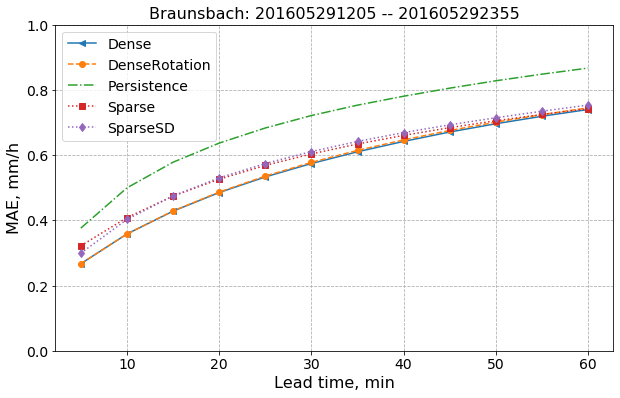

In [81]:
fig, ax = plt.subplots(figsize=(10,6))
ax = MAE_simple_plot(metrics_dict, ax)

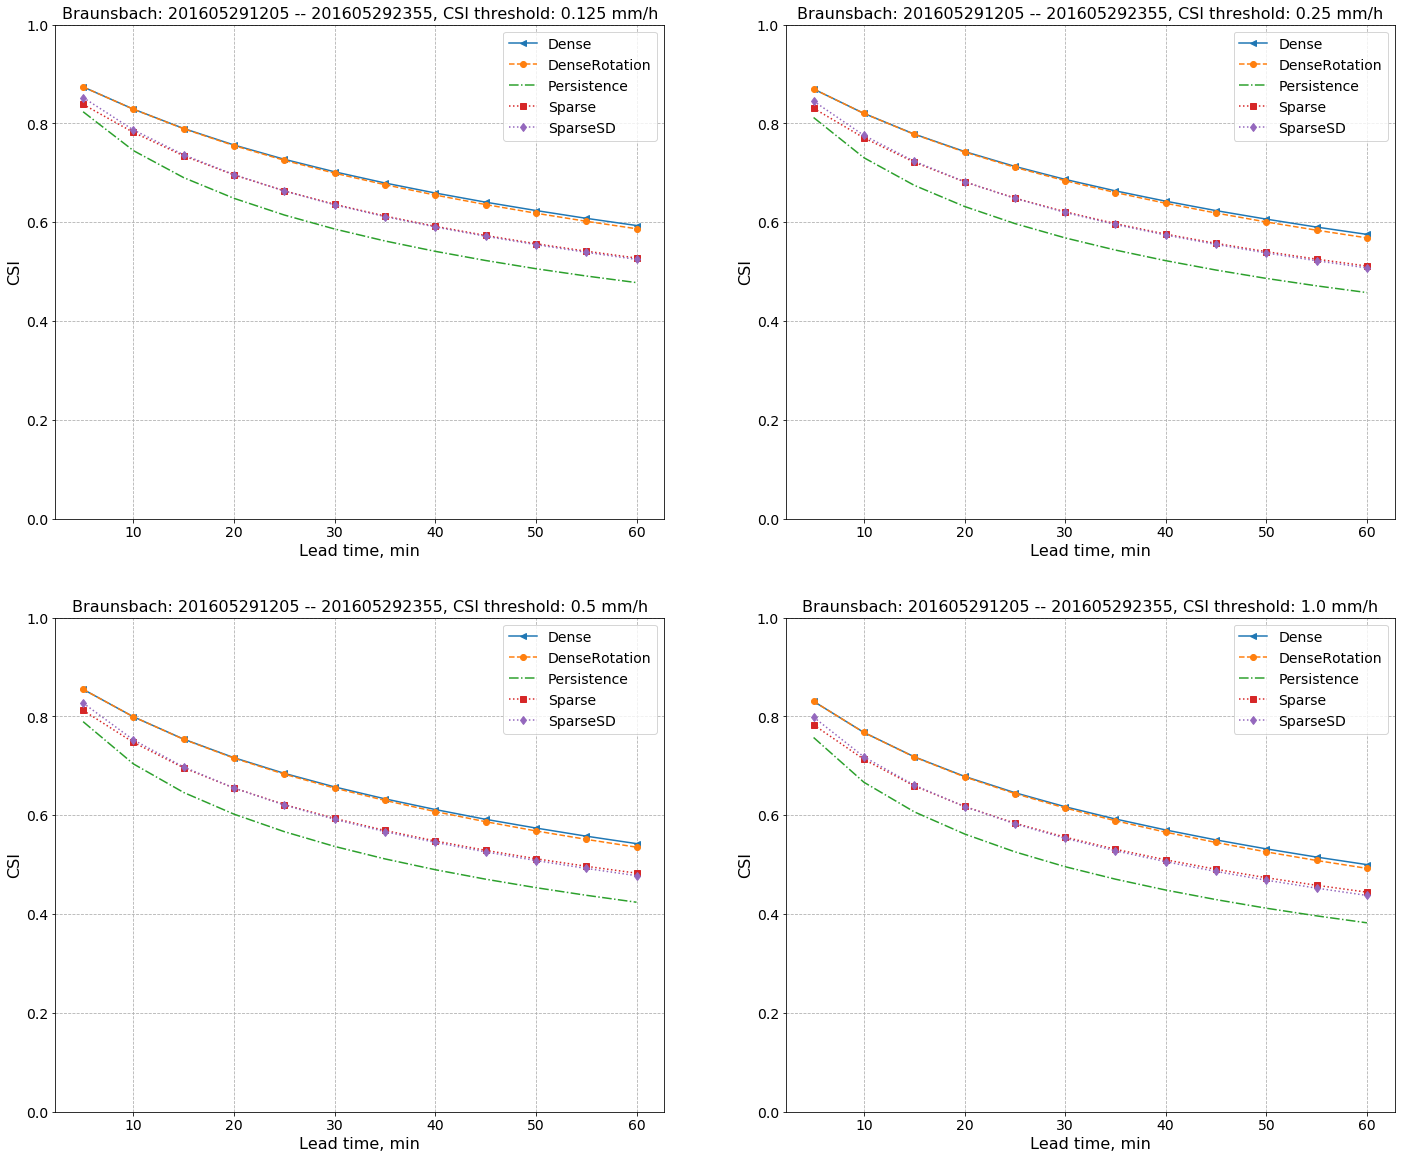

In [79]:
fig, axes = plt.subplots(2, 2, figsize=(24,20))
axes = axes.ravel()
for i, threshold in enumerate(['0.125', '0.25', '0.5', '1.0']):
    axes[i] = CSI_simple_plot(metrics_dict, threshold, axes[i])